In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/My Drive/Colab Notebooks
# pip install -e .

In [0]:
# Importing Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse, copy

from model import *
from utils import *
from measures import *

In [0]:
seed = 12345
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Hyperparamters
epochs = 14

gamma = 0.7
momentum = 0.9

use_cuda = torch.cuda.is_available()
model_init = Net().to(device)

In [4]:
train_losses, test_losses = [], []
# lrs = [3e-1, 3e-2, 3e-3, 3e-4, 3e-5, 3e-6]  
# batch_size = 64 
batch_sizes = [32,64,128,256]
lr = 3e-6 # good one - lowest validation loss among others

var_gradients_list = []  

for batch_size in batch_sizes:
    model = copy.deepcopy(model_init)
    tmp_list = []
    print ("batch_size::", batch_size)
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))
    optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    
    # Training 
    for epoch in range(1, epochs + 1):
        train_loss, grad_norms, grad_avg = train_get_grad(model, device, train_loader, optimizer, epoch, batch_size)
        train_losses.append(train_loss)
        test_loss = test(model, device, test_loader, batch_size)
        test_losses.append(test_loss)
        scheduler.step()
        
        # computing var_score over one epoch
        variance_score = compute_grad_variance(grad_norms, grad_avg)
        # print ("var score", variance_score)
        tmp_list.append(variance_score)
    var_gradients_list.append(tmp_list)
    
# show_losses(train_losses, test_losses)

batch_size:: 32
54000 6000 10000

Test set: Average loss: 0.6674, Accuracy: 7581/10000 (76%)


Test set: Average loss: 0.6190, Accuracy: 7682/10000 (77%)


Test set: Average loss: 0.5953, Accuracy: 7730/10000 (77%)


Test set: Average loss: 0.5864, Accuracy: 7751/10000 (78%)


Test set: Average loss: 0.5790, Accuracy: 7752/10000 (78%)


Test set: Average loss: 0.5753, Accuracy: 7762/10000 (78%)


Test set: Average loss: 0.5712, Accuracy: 7771/10000 (78%)


Test set: Average loss: 0.5699, Accuracy: 7771/10000 (78%)


Test set: Average loss: 0.5682, Accuracy: 7770/10000 (78%)


Test set: Average loss: 0.5679, Accuracy: 7773/10000 (78%)


Test set: Average loss: 0.5676, Accuracy: 7773/10000 (78%)


Test set: Average loss: 0.5661, Accuracy: 7772/10000 (78%)


Test set: Average loss: 0.5668, Accuracy: 7775/10000 (78%)


Test set: Average loss: 0.5663, Accuracy: 7775/10000 (78%)

batch_size:: 64
54000 6000 10000

Test set: Average loss: 0.5586, Accuracy: 7798/10000 (78%)


Test set: Average 

var_gradients:
 [[tensor(2.1262), tensor(1.8946), tensor(1.7337), tensor(1.6300), tensor(1.5905), tensor(1.5466), tensor(1.5346), tensor(1.5104), tensor(1.5010), tensor(1.4806), tensor(1.4816), tensor(1.4670), tensor(1.4829), tensor(1.4687)], [tensor(1.1729), tensor(1.0690), tensor(1.0335), tensor(0.9969), tensor(0.9736), tensor(0.9513), tensor(0.9406), tensor(0.9312), tensor(0.9303), tensor(0.9158), tensor(0.9254), tensor(0.9202), tensor(0.9089), tensor(0.9095)], [tensor(0.7602), tensor(0.6921), tensor(0.6593), tensor(0.6371), tensor(0.6194), tensor(0.6121), tensor(0.6081), tensor(0.5980), tensor(0.5925), tensor(0.5892), tensor(0.5904), tensor(0.5872), tensor(0.5834), tensor(0.5844)], [tensor(0.5091), tensor(0.4395), tensor(0.4234), tensor(0.4061), tensor(0.3991), tensor(0.3835), tensor(0.3860), tensor(0.3887), tensor(0.3789), tensor(0.3773), tensor(0.3801), tensor(0.3731), tensor(0.3771), tensor(0.3721)]]


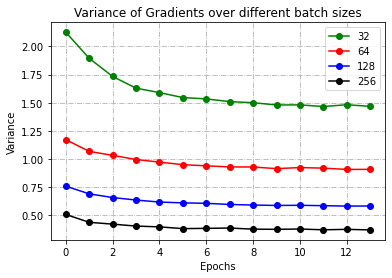

In [5]:
print ("var_gradients:\n", var_gradients_list)
import numpy as np
plt.plot(np.arange(epochs), var_gradients_list[0], marker='o', color = "g")
plt.plot(np.arange(epochs), var_gradients_list[1], marker='o', color = "r")
plt.plot(np.arange(epochs), var_gradients_list[2], marker='o', color = "b")
plt.plot(np.arange(epochs), var_gradients_list[3], marker='o', color = "k")
plt.grid(True, linestyle='-.')
plt.legend(["32","64","128","256"]) #loc='lower left'
plt.title("Variance of Gradients over different batch sizes")
plt.ylabel("Variance")
plt.xlabel("Epochs")
plt.show()	  

In [0]:
# divide train losses and then get generalisation gaps


In [6]:
train_losses, test_losses = [], []
lrs = [3e-2, 3e-3, 3e-4, 3e-5, 3e-6]  
batch_size = 64 
# batch_sizes = [32,64,128,256]
# lr = 3e-6 # good one - lowest validation loss among others

var_gradients_list_lr = []  

for lr in lrs:
    model = copy.deepcopy(model_init)
    tmp_list = []
    print ("lrs::", lr)
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))
    optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    
    # Training 
    for epoch in range(1, epochs + 1):
        train_loss, grad_norms, grad_avg = train_get_grad(model, device, train_loader, optimizer, epoch, batch_size)
        train_losses.append(train_loss)
        test_loss = test(model, device, test_loader, batch_size)
        test_losses.append(test_loss)
        scheduler.step()
        
        # computing var_score over one epoch
        variance_score = compute_grad_variance(grad_norms, grad_avg)
        # print ("var score", variance_score)
        tmp_list.append(variance_score)
    var_gradients_list_lr.append(tmp_list)
    
# show_losses(train_losses, test_losses)

lrs:: 0.03
54000 6000 10000

Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)

lrs:: 0.003
54000 6000 10000

Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)


Test set: Average loss: 2.3

Exception in thread Thread-211:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/pyth

KeyboardInterrupt: ignored

In [0]:
# print ("var_gradients:\n", var_gradients_list)
# import numpy as np
# plt.plot(np.arange(epochs), var_gradients_list, marker='o')
# plt.grid(True, linestyle='-.')
# # plt.legend() #loc='lower left'
# plt.title("Variance of Gradients")
# plt.ylabel("Variance")
# plt.xlabel("Epochs")
# plt.show()	  